In [1]:
# Load all libraries 
from PIL import Image
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [2]:
# Display Result Images
def griddisplay(image_list):
    rows = int(len(image_list) / 5) 
    fig1, axes_array = plt.subplots(rows, 5)
    fig1.set_size_inches(5,5)
    k=0
    for row in range(rows):
        for col in range(5):    
            im = np.array(Image.fromarray(image_list[k]).resize((100, 100), Image.ANTIALIAS))
            axes_array[row][col].imshow(im,cmap=plt.cm.gray) 
            axes_array[row][col].axis('off')
            k = k+1
    plt.show()

In [3]:
# Load all Training Images 
train_images=[]
for i in range(0,90):
    filename = r'C:\Users\power\Desktop\cv-task5\AllData\TrainingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    train_images.append(im)

TrainImages_num = len(train_images)

# Load all Testing Images 
test_images=[]
for i in range(0,60):
    filename =r'C:\Users\power\Desktop\cv-task5\AllData\TestingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    test_images.append(im)

TestImages_num = len(test_images)

In [4]:
# Getting Mean Face and Getting Eigen faces
flattened_images  =[]
for i in range(TrainImages_num):
    p= train_images[i].flatten()
    flattened_images.append(p)

A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

Mean= np.mean(A,1)
b= Mean.reshape(128,128)
resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))

zero_mean =[]
column =0
Zero_mean_matrix= np.ones((16384,TrainImages_num))
for values in flattened_images:
    zm= A[:,column] - Mean         # zm = values - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] =zm
    zm_images = zm.reshape(128,128)
    zero_mean.append(zm)
    column = column +1

d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/425
u_list =[]
w2, v2 = la.eigh(d)

for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)                        
    u = u / np.linalg.norm(u)
    u_i= u.reshape(128,128)
    u_list.append(u_i)

C:\Users\power\AppData\Local\Temp\ipykernel_12236\3475385436.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))


In [5]:
# Getting Weights
dict ={}
def Reconstruct(k):
    weights=np.zeros((TrainImages_num,k))
    matrixU = np.zeros((16384,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,TrainImages_num):
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
        weights[face_num,:] =w

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(Mean)
        reshape_face = face.reshape(128,128)
        rec_face.append( reshape_face)
    dict[k] = weights

Reconstruct(90)


In [ ]:
# Testing Images
y_pred=[]

def Project(k, zero_mean_test, threshold):
    matrixU = np.zeros((16384, k))
    c = 0
    name =""
    for val in range(k-1, -1, -1):
        matrixU[:, c] = u_list[val].flatten()
        c = c + 1
    w = np.dot(np.transpose(matrixU), np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist = []
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))

    print ("Minimum Distance :  ", np.min(dist))
    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    zero_mean_test = zero_mean_test + np.transpose(Mean)
    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face + np.transpose(Mean)
    reshape_face = face.reshape(128, 128)

    if np.min(dist) < threshold:  
        index = nearest_face
        if index in range(0,15):
            name="Nada"
            y_pred.append(0)
        elif index in range(15,30):
            name="kareman"
            y_pred.append(1)
        elif index in range(30,45):
            name="naira"
            y_pred.append(2)
        elif index in range(45,60):
            name="mayar"
            y_pred.append(3)
        elif index in range(60,75):
            name="Ghofran" 
            y_pred.append(4)
        elif index in range(75,90):
            name="Unknown" 
            y_pred.append(5)
    else:
        index = -1
        name = 'Unknown'
        y_pred.append(5)
    return  name, reshape_face
    
def runs(k):
    for num in range(TestImages_num):
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test - np.transpose(Mean)
        name, face = Project(k, zero_mean_test, 80)  # threshold = 80
        fig1, axes_array = plt.subplots(1, 2)
        fig1.set_size_inches(3, 3)
        axes_array[0].imshow(t, cmap=plt.cm.gray)
        axes_array[0].axis('off')
        axes_array[0].set(title='Test Face')
        axes_array[1].imshow(face, cmap=plt.cm.gray)
        axes_array[1].axis('off')
        axes_array[1].set(title = name)
        plt.show()

print('\t\tk = 90')
runs(90)

print ("Length Of Test_Predicted : ", len(y_pred))


In [7]:
# Testing Images Labels
y_test=[0,0,0,0,0,0,0,0,0,0]       #nada
for i in range(10):
    y_test.append(1)                #kareman 
for i in range(10):
    y_test.append(2)               #naira
for i in range(10):
    y_test.append(3)                 #mayar
for i in range(10):
    y_test.append(4)                  #ghofran 
for i in range(10):
    y_test.append(5)                  #unknown

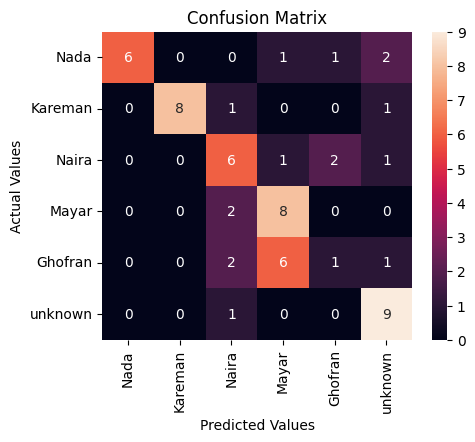

In [8]:
# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Nada','Kareman','Naira','Mayar','Ghofran','unknown'], 
                     columns = ['Nada','Kareman','Naira','Mayar','Ghofran','unknown'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Text(0.5, 1.0, 'Receiver operating characteristic for multi-class data')

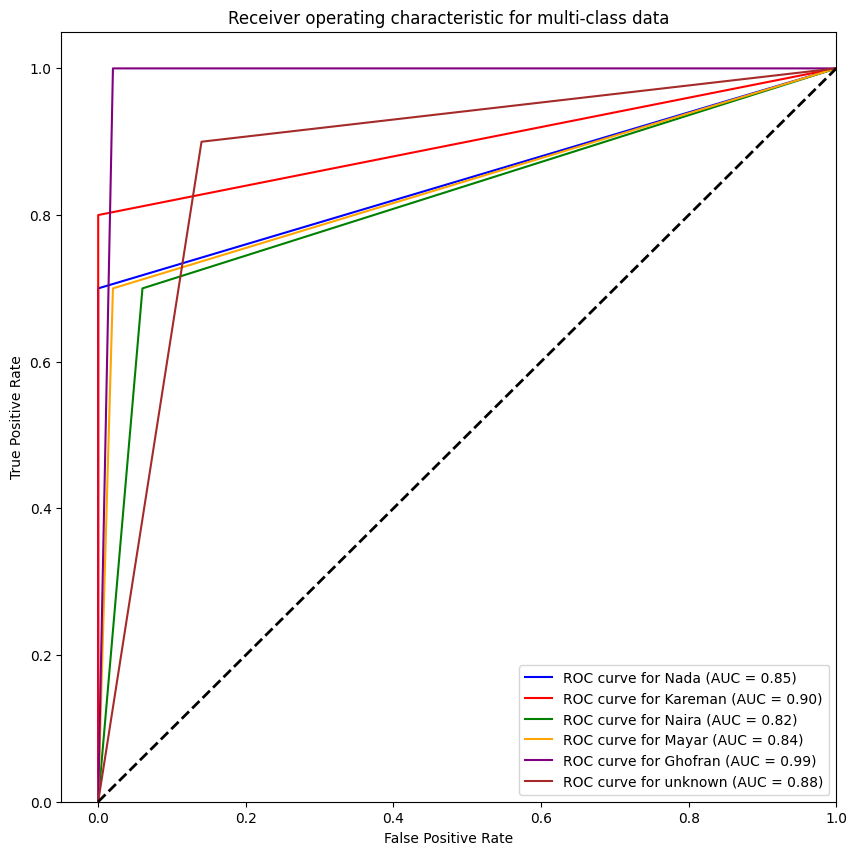

In [49]:
# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2,3,4,5])
y_pred = label_binarize(y_pred, classes=[0, 1, 2,3,4,5])
n_classes = y_test.shape[1]
target_names=['Nada','Kareman','Naira','Mayar','Ghofran','unknown']
fpr = {}
tpr = {}
roc_auc ={}
lw =2 
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
fig, ax = plt.subplots(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, i],
        y_pred[:, i],
        name=f"ROC curve for {target_names[i]}",
        color=color,ax=ax
    )
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')

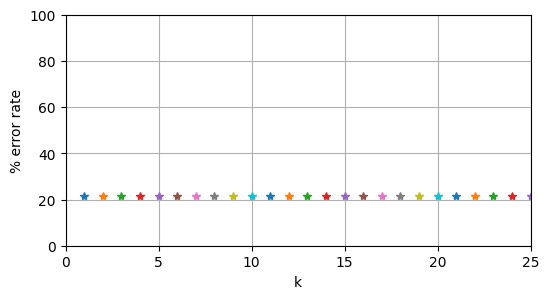

In [50]:
def Error(k,threshold):
    Nonfaces = 13
    total_images = 60
    nf_detected = 0
    matrixU = np.zeros((16384,k))
    c = 0
    
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    
    for t in test_images:
        test = t.flatten()
        zero_mean_test = test-np.transpose(Mean)
        w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
        original_w_k =dict[k]
        dist =[]
        for wt_vectors in original_w_k:
            dist.append(np.linalg.norm(wt_vectors-w.T))
        
        if np.min(dist) > threshold:
            nf_detected = nf_detected + 1

    
    error_percentage = ((Nonfaces - nf_detected)/total_images) *100
    return error_percentage

xt =[]
for x in range(1,90):
    Reconstruct(x)
    xt.append(x)


fig, axes1 = plt.subplots(1, 1)
fig.set_size_inches(6,3)
for x_pts in xt:
    y= Error(x_pts,80)
    axes1.plot(x_pts, y,marker='*')
axes1.set(xlabel="k",ylabel="% error rate",ylim=(0,100),xlim=(0,25))
plt.grid(True)
plt.show()
